# Clear-sky detection

    1) compute kt = I/Iclr  (Ineicheon model)  7:00-17:00 or theta <= 85deg
    2) 1 day = 40 points of kt 
    3) if majority of 40 points of kt >= THRESHOLD --> regard as clear-sky day  --> output = tentative clear-sky days 
    4) compute cosine similarity between Iclr and candidates in 3) 
    5) rank these cosine similarity scores ---> plot the XX best ones using visualization as complimentary
    6) group all those XX best ones (assume these XX ones are quite large and cover many stations) into each stations
    7) estimate TL for each station using LS 
    8) plot TL for all stations using heat map

# Import data

In [1]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import math
from sklearn.linear_model import LinearRegression

import seaborn as sns
import scipy
from scipy.stats import gaussian_kde

from SolarCalculator.clearskycal import calsolar

In [2]:
plant = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/plant_metadata.csv',
                   usecols = lambda column : column != 'Unnamed: 0')

In [3]:
measurment_GHI = pd.read_csv('/Users/khunnoot/Desktop/year4/senior_project/solarmap_project/clear-sky-detection/measurment_GHI.csv',
                             parse_dates=['Datetime'],index_col='Datetime')
measurment_GHI.rename(columns = {'ims_wpm2':'I','iclr_wpm2':'Iclr'}, inplace = True)
measurment_GHI['zna'] = np.arccos(measurment_GHI.czna)*180/np.pi
measurment_GHI['k'] = measurment_GHI.I/measurment_GHI.Iclr
measurment_GHI.replace([np.inf, -np.inf], np.nan, inplace=True)
measurment_GHI.dropna(inplace = True)
measurment_GHI['date'] = measurment_GHI.index.date

In [17]:
measurment_GHI

,site_name,I,Iclr,AM,czna,zna,k,date
Datetime,,,,,,,,
2022-02-01 07:00:00+07:00,ISL001,72.941510,7.285804,12.640202,0.067315,86.140234,10.011457,2022-02-01
2022-02-01 07:30:00+07:00,ISL001,146.175600,81.368288,5.250524,0.185443,79.313048,1.796469,2022-02-01
2022-02-01 08:00:00+07:00,ISL001,228.079400,189.533857,3.310866,0.299147,72.593619,1.203370,2022-02-01
2022-02-01 08:30:00+07:00,ISL001,297.216500,303.235701,2.448517,0.406482,66.015977,0.980150,2022-02-01
2022-02-01 09:00:00+07:00,ISL001,282.950100,412.788698,1.972317,0.505611,59.628096,0.685460,2022-02-01
...,...,...,...,...,...,...,...,...
2022-10-22 15:30:00+07:00,ISL056,330.636200,466.637901,1.802704,0.553498,56.392677,0.708550,2022-10-22
2022-10-22 16:00:00+07:00,ISL056,204.176000,353.436064,2.203073,0.452253,63.111676,0.577689,2022-10-22
2022-10-22 16:30:00+07:00,ISL056,88.353200,234.536326,2.899660,0.342438,69.974509,0.376714,2022-10-22


# Calculate cosine similirality in each site

In [4]:
def cosine_similarity(df_site, threshold_k, percent_majority) :
    date = [str(d) for d in df_site.groupby(by = df_site.index.date).mean().index]
    df_clear = []
    for k in range(len(date)) :
        count = 0
        ee1 = df_site.loc[date[k]]
        b = np.where(ee1.k > threshold_k , 1, 0)
        percent = b.sum()/len(ee1)    
        
        if percent > percent_majority :
            I = ee1['I'].values**2
            Iclr = ee1['Iclr'].values**2
            IIclr = ee1['I'].values * ee1['Iclr'].values
            cosine = IIclr.sum()/(I.sum() * Iclr.sum())**0.5
            df_clear.append({'date' : date[k], 'cosine' : cosine}) 
            
    similarity = pd.DataFrame(df_clear).sort_values(by = 'cosine' , ascending = False)
    
    return similarity

# Calculate TL all site

In [5]:
def clearsky_detection(df, threshold_k, percent_majority, number_clearday) :
    TL_list = []
    TL_df = pd.DataFrame()
    for i in range(56):
        df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[i])]
        if i == 31: # site ISL032 have usable GHI in 2022-02 - 2022-05-1
            df_site = df_site.loc['2022-02-01':'2022-05-01'] 

        if i == 44 or i == 53: # site ISL045 don't have GHI and GHI in ISL045 is range (20-70 W/m2)
            TL_list.append({'site_name':plant.site_name[i], 'lat' : plant.lat[i], 'lon' : plant.lng[i], 'TL' : 'NaN'})
            pass
        else :
            similarity = cosine_similarity(df_site, threshold_k, percent_majority)
            clearday = similarity[:number_clearday-1].copy()
            d = [str(d) for d in clearday.date]
            df = pd.DataFrame()
            for k in range(len(d)):
                df = pd.concat([df,df_site.loc[d[k]]])
            df = df[df.I > 0]
            I0 = 1366.1
            h = plant.alt[0]
            f1 = math.exp(-h/8000);
            f2 = math.exp(-h/1250);
            a1 = (h*5.09e-5) + 0.868;
            a2 = (h*3.92e-5) + 0.0387;
            df['y']= (f1 - f2)*a2*df['AM'] + np.log(df['I'] / (a1 * I0 * df['czna']))
            df['x']= - a2 * f2 * df['AM']

            model = LinearRegression()
            model.fit(df.x.values.reshape(-1, 1) , df.y.values)
            TL = model.coef_[0]
            TL_list.append({'site_name':plant.site_name[i], 'lat' : plant.lat[i], 'lon' : plant.lng[i], 
                            'alt' : plant.lat[i], 'criterion_pass' : len(similarity), 'TL' : TL})
            
            TL_df = pd.concat([TL_df, df])
    TL_all = LinearRegression()
    TL_all.fit(TL_df.x.values.reshape(-1, 1) , TL_df.y.values)
    TL56site = TL_all.coef_[0]

    df_TL = pd.DataFrame(TL_list)
    return df_TL, TL56site
    

In [15]:
df_TL, TL56site = clearsky_detection(measurment_GHI, 
                                     threshold_k = 0.9, 
                                     percent_majority = 0.7, 
                                     number_clearday = 7)

In [16]:
print('TL all 56 sites = ',TL56site)
df_TL

TL all 56 sites =  3.5557648576184726


,site_name,lat,lon,alt,criterion_pass,TL
0,ISL001,14.005230,100.519403,14.005230,21.0,3.589106
1,ISL002,13.706500,100.281200,13.706500,15.0,1.773215
2,ISL003,13.653800,100.522300,13.653800,23.0,3.697915
3,ISL004,13.635425,100.632181,13.635425,30.0,3.559109
4,ISL005,13.692800,100.897200,13.692800,42.0,4.13653
5,ISL006,13.808630,100.439000,13.808630,17.0,2.804249
6,ISL007,15.635300,100.476300,15.635300,28.0,3.123448
7,ISL008,14.306600,100.611600,14.306600,31.0,3.05957
8,ISL009,18.128400,100.144000,18.128400,38.0,3.244795
9,ISL010,13.808060,100.447297,13.808060,23.0,3.424159


# visualize in each site

/var/folders/k4/2flb1pz9447c85n88k4_n8jm0000gn/T/ipykernel_73063/1280283980.py:32: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  fig.legend(l1, labels=['I','Iclr'],fontsize=20);


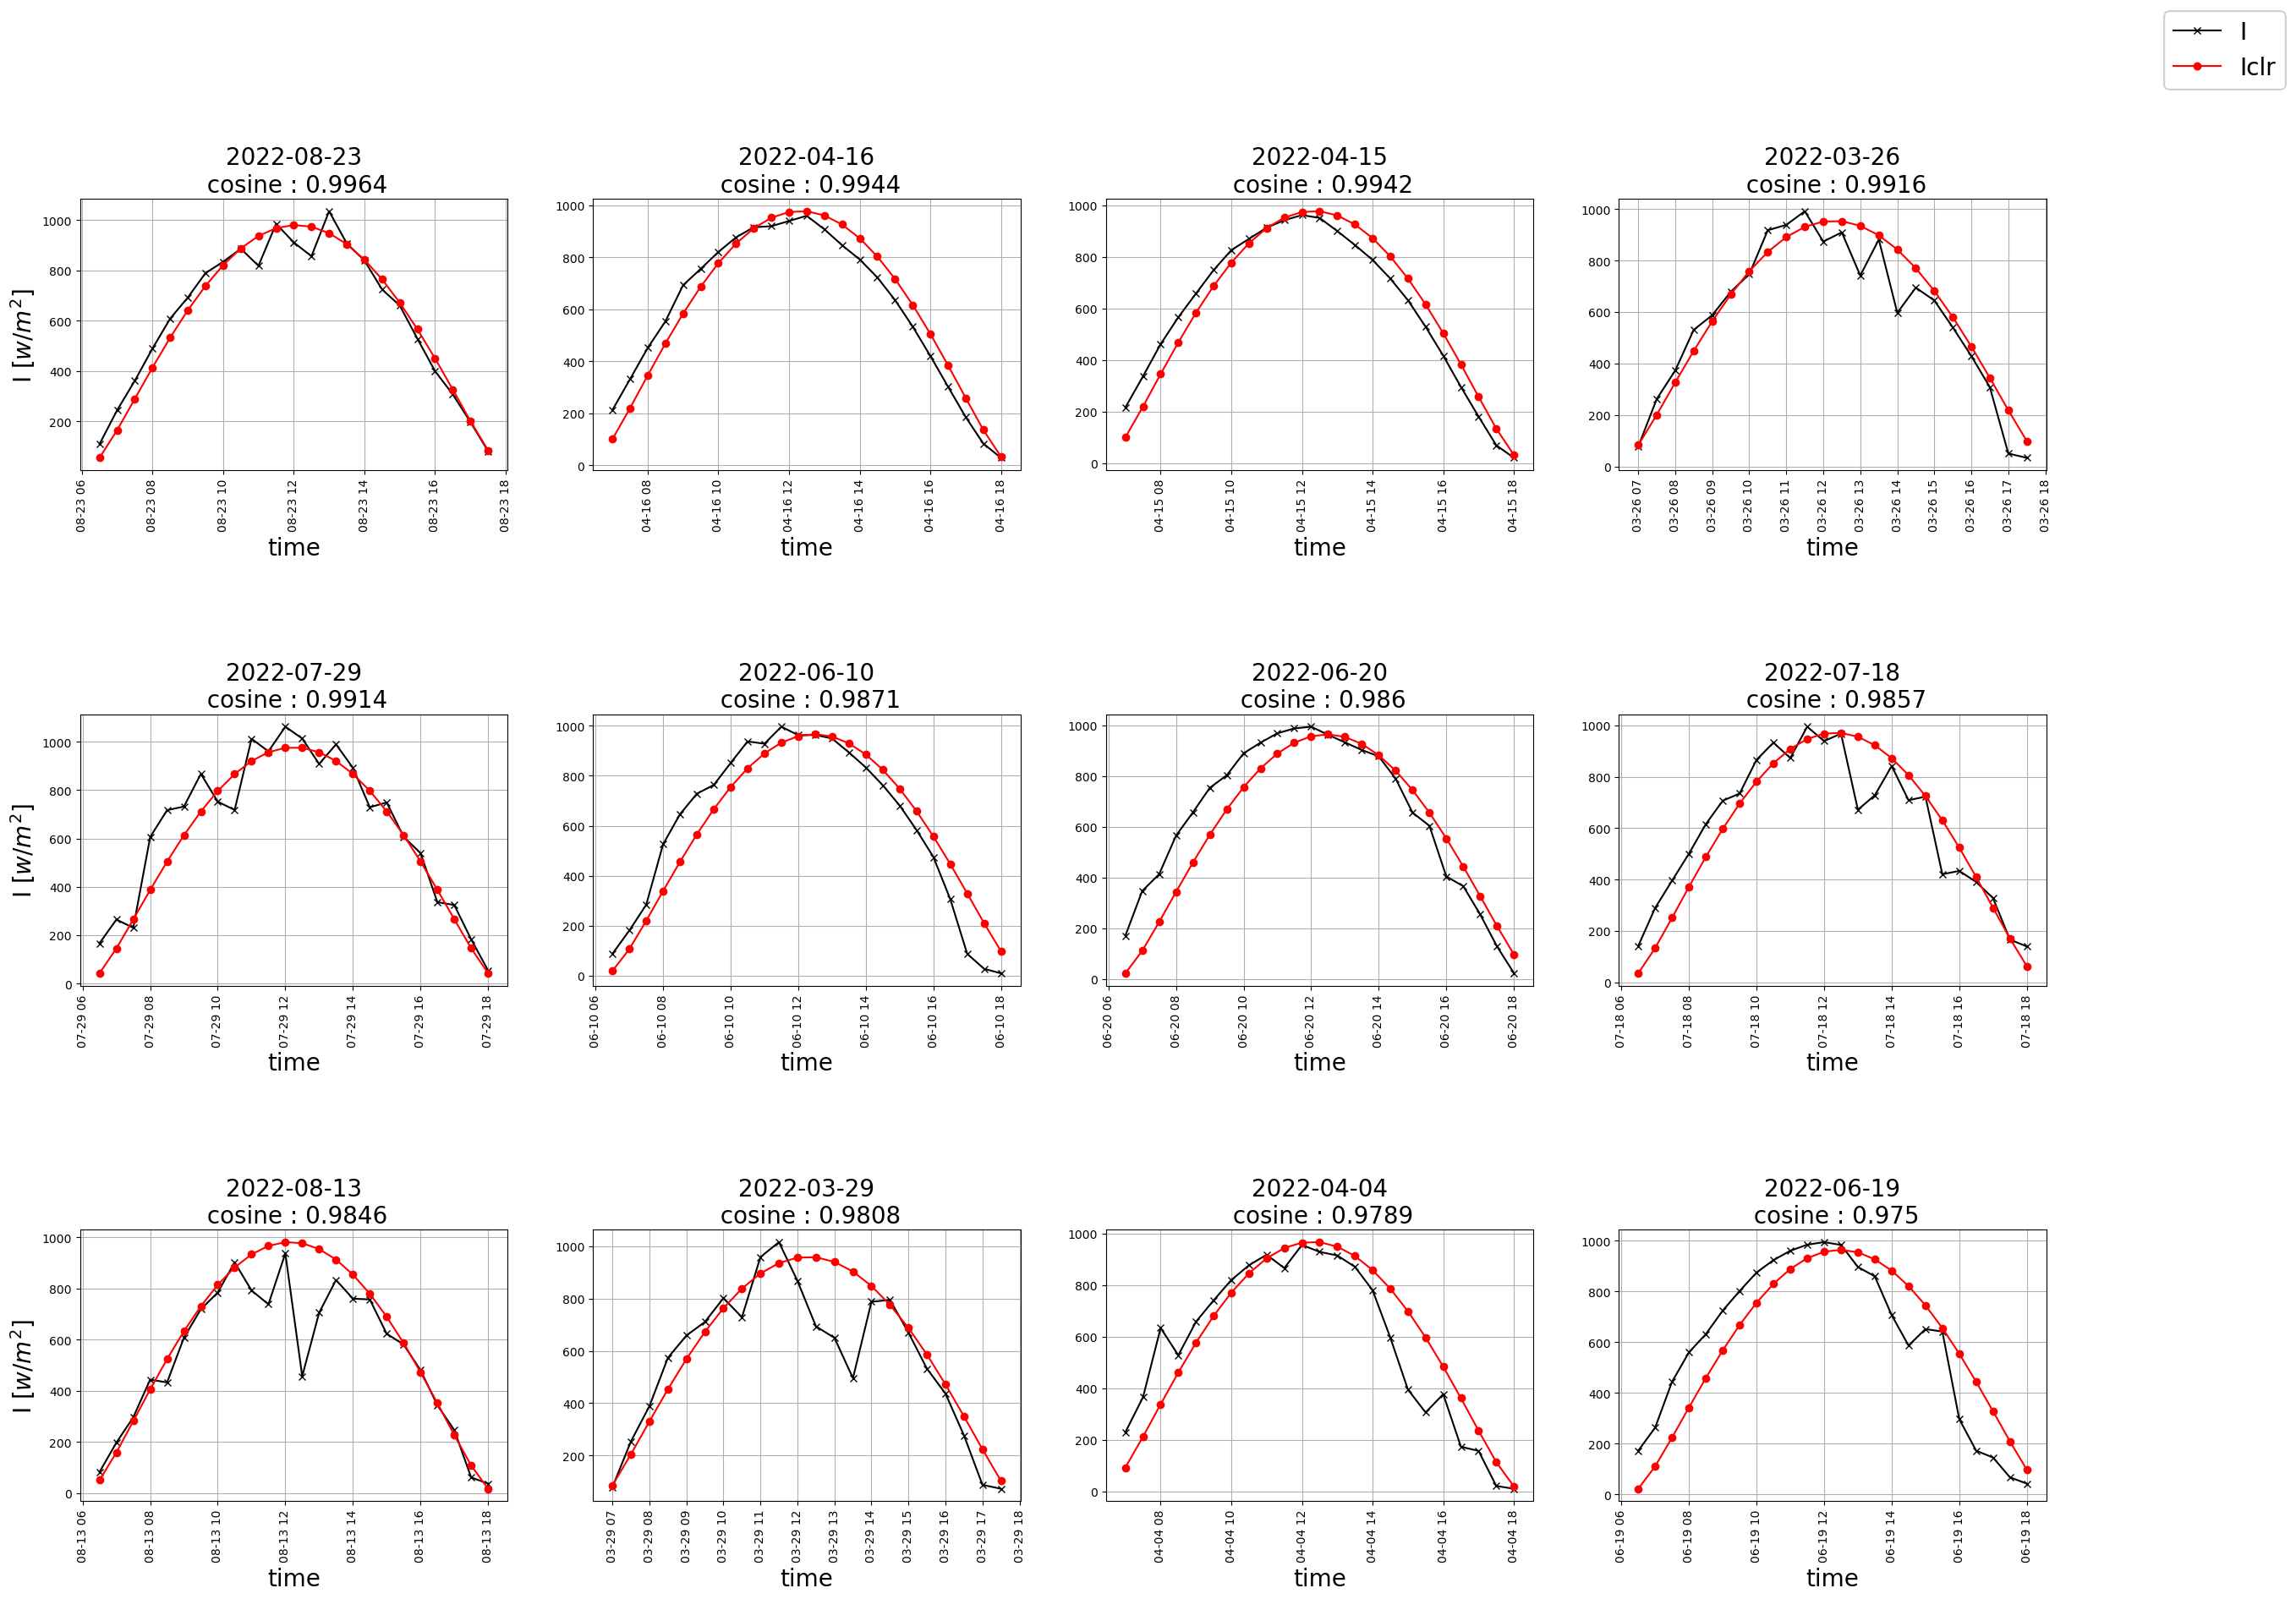

In [12]:
site = 48

df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[site-1])]
cosine_site = cosine_similarity(df_site, threshold_k = 0.9, percent_majority = 0.65)

clear_date = [str(d) for d in cosine_site.date]
cosine = [ d for d in cosine_site.cosine]

nrow= int(len(cosine_site)/4)
ncol = 4
name_model = ['Iclr']
color=['red']

####################################
fig, ax = plt.subplots(nrow,ncol, figsize=(30,20))
ax = ax.reshape(1,-1)[0]
for k in range(len(ax)):
    plt.subplot(nrow, ncol, k+1)
    ee1 = df_site.loc[clear_date[k]]
    l1 = plt.plot(ee1.I, '-x', color = 'black')
    for e in range(len(name_model)):
        l2 = plt.plot(ee1[name_model[e]], '-o', color =color[e])
    
    if k%4 == 0:
        plt.ylabel(r'I $[w/m^2]$', fontsize=20)
    plt.xticks(rotation = 'vertical');
    cos = round(cosine[k],4)
    plt.title(clear_date[k] + '\n cosine : '+ str(cos),fontsize=20)
    plt.xlabel('time',fontsize=20)
    plt.grid(True)
    plt.subplots_adjust(hspace=0.9)
    fig.legend(l1, labels=['I','Iclr'],fontsize=20);

In [24]:
# measurment_GHI[measurment_GHI.site_name == 'ISL048'][['I','Iclr']].loc['2022-03-16'].plot()

In [9]:
site = 53

number_clearday = 13
df_site = measurment_GHI[(measurment_GHI.zna < 85) & (measurment_GHI.site_name == plant.site_name[site-1])]
similarity = cosine_similarity(df_site, 0.9, 0.65)
clearday = similarity[:number_clearday-1].copy()
d = [str(d) for d in clearday.date]
df = pd.DataFrame()
for k in range(len(d)):
    df = pd.concat([df,df_site.loc[d[k]]])

df = df[df.I > 0]
I0 = 1366.1
h = plant.alt[site-1]
f1 = math.exp(-h/8000);
f2 = math.exp(-h/1250);
a1 = (h*5.09e-5) + 0.868;
a2 = (h*3.92e-5) + 0.0387;
df['y']= (f1 - f2)*a2*df['AM'] + np.log(df['I'] / (a1 * I0 * df['czna']))
df['x']= - a2 * f2 * df['AM']

model = LinearRegression()
model.fit(df.x.values.reshape(-1, 1) , df.y.values)
TL = model.coef_[0]
print('TL = ', TL)

TL =  3.14595573731764


In [ ]:
# df.plot.scatter(x='x', y='y', c='DarkBlue')

In [10]:
import folium
from folium.plugins import HeatMap, HeatMapWithTime

df = df_TL
df.dropna(inplace = True)

# Create a map centered on the first coordinate (you can adjust the coordinates and zoom level)
map_center = [df['lat'].iloc[46], df['lon'].iloc[46]]
map_zoom = 14
map_obj = folium.Map(location=map_center, zoom_start=map_zoom)

# Add markers for each coordinate with the TL value as a popup
for index, row in df.iterrows():
    latitude, longitude, tl_value, site = row['lat'], row['lon'], row['TL'], row['site_name']
    popup_text = f"Site: {site} " f"TL: {tl_value}"
    folium.Marker(location=[latitude, longitude], popup=popup_text).add_to(map_obj)

# Create a list of (latitude, longitude, weight) tuples for the HeatMap
heatmap_data = [(row['lat'], row['lon'], row['TL']) for index, row in df.iterrows()]

# Add HeatMap layer to the map
HeatMap(heatmap_data).add_to(map_obj)


# map_obj.save("map_with_markers_and_heatmap.html")
map_obj
